<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/covidradio_weighted_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data.zip

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/balancedGenerator.py


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace data/test/COVID/COVID-672.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
--2021-08-24 06:35:05--  https://raw.githubusercontent.com/karencfisher/COVID19/main/balancedGenerator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3508 (3.4K) [text/plain]
Saving to: ‘balancedGenerator.py’

balancedGenerator.p 100%[===================>]   3.43K  --.-KB/s    in 0s      

2021-08-24 06:35:05 (31.7 MB/s) - ‘balancedGenerator.py’ saved [3508/3508]



In [2]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

from balancedGenerator import balancedGenerator

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Get metadata on training set 

In [3]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

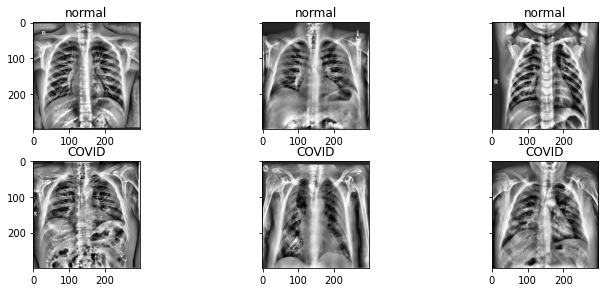

In [4]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

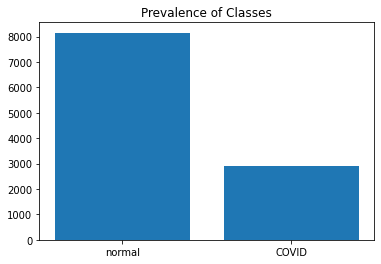

In [5]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Data generators to import images into the classifier

In [6]:
datagen = ImageDataGenerator(rescale=1./255.)

train_path = os.path.join(data_path, 'train')
'''train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)'''

train_gen = balancedGenerator(train_path, classes, datagen, (299, 299), class_mode='binary')

valid_path = os.path.join(data_path, 'valid')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                       image   label
0       COVID/COVID-2301.png   COVID
1       COVID/COVID-1908.png   COVID
2       COVID/COVID-2933.png   COVID
3       COVID/COVID-2023.png   COVID
4       COVID/COVID-1451.png   COVID
...                      ...     ...
5779  normal/Normal-2784.png  normal
5780  normal/Normal-5365.png  normal
5781  normal/Normal-3414.png  normal
5782  normal/Normal-2325.png  normal
5783     normal/Normal-4.png  normal

[5784 rows x 2 columns]
Found 5784 validated image filenames belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [12]:
batch = train_gen.next()

In [13]:
batch[1]

array([1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

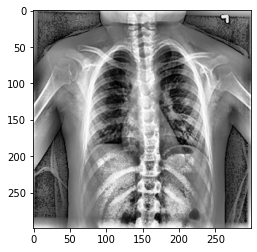

In [14]:
plt.imshow(batch[0][0])

#### Build a simple CNN as a baseline

In [ ]:
model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
                    MaxPooling2D(2, 2),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(256, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                   
                    Flatten(),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 128)      

#### Weighted binary crossentropy loss function

In [ ]:
neg_w = np.sum(train_gen.classes) / len(train_gen.classes)
pos_w = 1 - neg_w

def Weighted_Loss(pos_w, neg_w, epsilon=1e-7):
  def weighted_loss(y_true, y_pred):
    pos_loss = -1 * K.mean(pos_w * y_true * K.log(y_pred + epsilon))
    neg_loss = -1 * K.mean(neg_w * (1 - y_true) * K.log(1 - y_pred + epsilon))
    loss = pos_loss + neg_loss
    return loss
  return weighted_loss

#### Compile and train

In [ ]:
model.compile(loss=Weighted_Loss(pos_w, neg_w), optimizer='adam', metrics=['accuracy'])

stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit(train_gen,
                    epochs=25,
                    validation_data=valid_gen,
                    verbose=1,
                    callbacks=[stop, reduce_lr])

Epoch 1/25
346/346 [==============================] - 38s 109ms/step - loss: 0.2263 - accuracy: 0.6355 - val_loss: 0.1744 - val_accuracy: 0.8609
Epoch 2/25
346/346 [==============================] - 37s 106ms/step - loss: 0.1113 - accuracy: 0.8794 - val_loss: 0.0983 - val_accuracy: 0.9109
Epoch 3/25
346/346 [==============================] - 37s 108ms/step - loss: 0.0712 - accuracy: 0.9291 - val_loss: 0.0920 - val_accuracy: 0.9138
Epoch 4/25
346/346 [==============================] - 37s 106ms/step - loss: 0.0565 - accuracy: 0.9402 - val_loss: 0.0804 - val_accuracy: 0.9464
Epoch 5/25
346/346 [==============================] - 37s 107ms/step - loss: 0.0439 - accuracy: 0.9557 - val_loss: 0.0597 - val_accuracy: 0.9449
Epoch 6/25
346/346 [==============================] - 37s 106ms/step - loss: 0.0325 - accuracy: 0.9681 - val_loss: 0.0920 - val_accuracy: 0.9406
Epoch 7/25
346/346 [==============================] - 37s 106ms/step - loss: 0.0273 - accuracy: 0.9714 - val_loss: 0.0639 - val_ac

In [ ]:
model_path = os.path.join(BASE_PATH, 'weighted_model.h5')
model.save(model_path)

#### Evaluate the model

(Accuracy is not everything.)

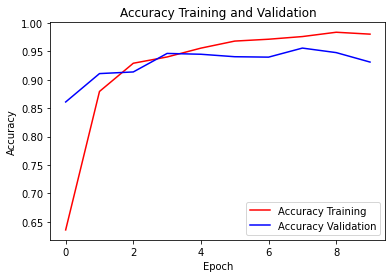

In [ ]:
plt.plot(history.history['accuracy'], 'r', label='Accuracy Training')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [ ]:
score = model.evaluate(valid_gen)
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 4s 86ms/step - loss: 0.0597 - accuracy: 0.9449
Accuracy Score = 94.0%


#### Calculate confusion matrix, precision, recall, f1

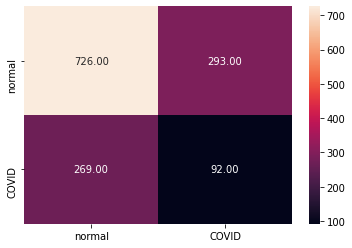

In [ ]:
y_true = valid_gen.classes
y_pred = model.predict(valid_gen)
y_pred = y_pred.reshape(-1)
y_pred = y_pred > 0.5
cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

In [ ]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

      normal       0.73      0.71      0.72      1019
       COVID       0.24      0.25      0.25       361

    accuracy                           0.59      1380
   macro avg       0.48      0.48      0.48      1380
weighted avg       0.60      0.59      0.60      1380



#### ROC-AUC curve and AUC score

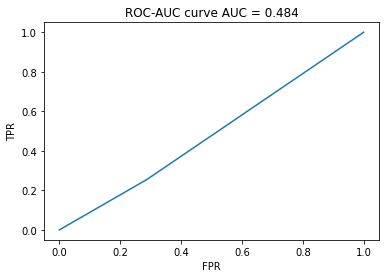

In [ ]:
fpr, tpr, thresh = roc_curve(y_true, y_pred)
auc_score = round(roc_auc_score(y_true, y_pred), 3)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curve AUC = {auc_score}')
plt.show()

#### Calculate Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [ ]:
# tp, fp, tn, fn
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

# sensitivity, specificity
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Accuracy = {round(accuracy * 100, 2)}%')
print(f'Sensitivity = {round(sensitivity * 100, 2)}%')
print(f'Specificity = {round(specificity * 100, 2)}%')
    
# Calculate PPV according to Bayes Theorem
prev = np.sum(y_true) / len(y_true)
numerator = sensitivity * prev
denominator = sensitivity * prev + (1 - specificity) * (1 - prev)
ppv = numerator / denominator
print(f'Positive Predictive Value = {round(ppv * 100, 2)}%')


Accuracy = 59.28%
Sensitivity = 25.48%
Specificity = 71.25%
Positive Predictive Value = 23.9%


$$ P^4 $$ 
#### (Pretty Piss Poor Performance)

But it is a baseline, and we are getting the metrics to be used worked out.